## Imports

In [ ]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from time import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools

import glob
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import sklearn  # scikit-learn
from skimage import io
import tensorflow as tf
import gc
import cv2
# import tensorflow models
import sys
from tensorflow.keras.utils import to_categorical
import math
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.keras.__version__)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.efficientnet as efn

2.6.0


## Utils

Here we define two functions used to vizualize the data classification, in the form of a confusion matrix as well as finding the false positives that we wish to plot.

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def divise_prediction(y_pred,y_test):
  """
    This function divides the prediction of all the 4 areas of prediction.
  """
  fp = []
  fn = []
  tn = []
  tp = []
  count = 0
  for i in range(y_pred.shape[0]):
    # false positive
    if (y_pred[i] == 1 and y_test[i] == 0):
      fp.append(i)
    # false negative
    if (y_pred[i] == 0 and y_test[i] == 1):
      fn.append(i)
    # correct class 0
    if (y_pred[i] == 0 and y_test[i] == 0):
      tn.append(i)
    # correct class 1
    if (y_pred[i] == 1 and y_test[i] == 1):
      tp.append(i)  
  if((len(tp)+len(fp)) != 0 and (len(tp)+len(fn)) != 0):
    precision = len(tp)/(len(tp)+len(fp))
    recall = len(tp)/(len(tp)+len(fn))
    f1 = 2*(precision*recall)/(precision+recall)
  else:
    print("Division by zero... change tr!")
    
  print("false positive = ", len(fp),"\nfalse negative = ", len(fn),
        "\ntrue negative = ", len(tn) ,"\ntrue positive = ", len(tp))

  print("precision = ", precision, "\nrecall = ", recall, "\nf1 = ", f1)
  return   fp , fn , tn , tp 
  

## Create cell division for all images into their types
First we download the file with the images

In [ ]:
gdd.download_file_from_google_drive(file_id='1HJMWxmIjXW32hles0t0WoMBYlYOrYRpe',
                                    dest_path = '/content/prim.zip', overwrite=True)

with zipfile.ZipFile('/content/prim.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

## Create arrays for all types of cells
 - all_cells[][][] : list with all the images of the different types of cells
    - the list is divided into 3 divisions: 
        - the first divides the cells into groups of cells with similar caracteristics
        - the second divides each group into the final classification of the cell
        - the third divides the class of cells into images ([:,:,0:3]) 

- group_names : list with all names of each group for the first division of all cells
- class_names : list with all final classes of images

In [ ]:
def normalization(img):
    pixels = np.asarray(img)
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # calculate global mean and standard deviation
    mean, std = pixels.mean(), pixels.std()
    # global standardization of pixels
    pixels = (pixels - mean) / np.max(std, 1e-8)
    return pixels

In [ ]:
def create_cells(g_list):
    """ 
    g_list: name of groups we wish to use
    """
    # creat list handels
    all_cells = []
    group_names = []
    all_class_names = []

    # go through all the types of groups
    for filename in glob.glob('/content/HEP annot/*'): 
        # save their names
        group = filename[len("/content/HEP annot/"):]
        if group in g_list:
            group_names.append(group)
            names = []
            class_cells = []
            class_names = []
            # go through all the classes of cells within a group
            for cell_class in glob.glob(filename+'/*'):
                # save their names
                class_names.append(cell_class[len(filename)+1:])

                # go through all the images of cells within a class
                images = []
                for cell in glob.glob(cell_class+'/*'):
                    #print(cell)
                    img = cv2.imread(cell)
                    images.append(normalization(img))
                # save images to class 
                class_cells.append(images)
            # save all data  in final list
            all_cells.append(class_cells)
            all_class_names.append(class_names)
    return  all_cells, group_names, all_class_names

In [ ]:
all_cells, group_names, all_class_names = create_cells(["mouchete", "Cyto", "nucleole"])

In [ ]:
group_names

['nucleole', 'Cyto', 'mouchete']

In [ ]:
all_class_names

[['nucleole fibrillarine', 'nucleole RNA pol I', 'nucleole ThTo'],
 ['CytoD SRP RiboP',
  'Cyto filamenteux actine',
  'Cyto atypique MDA5',
  'CytoD PL12',
  'Cyto granuleux',
  'Cyto Golgi',
  'Cyto Ponctue Jo1',
  'Cyto filamenteux Vimentine',
  'CytoD PL7',
  'CytoD EJ',
  'Cyto APL',
  'Cyto Ponctue Somes',
  'Cyto atypique HMCOAR',
  'Cyto Ponctue GW',
  'Cyto Fibreux'],
 ['mouchete TIF1',
  'mouchete NXP2',
  'mouchete M0',
  'mouchete fin',
  'mouchete RNApolIII',
  'mouchete SAE1',
  'mouchete dot RNP',
  'Mouchete SSA']]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


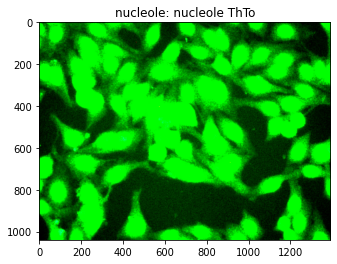

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


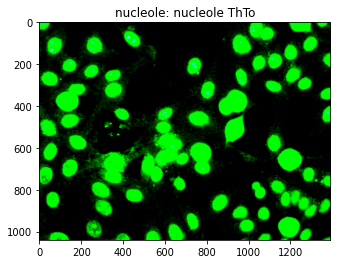

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


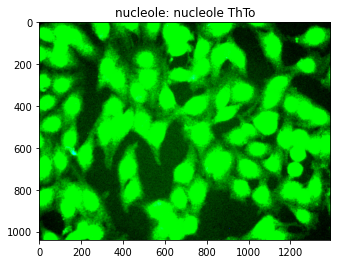

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


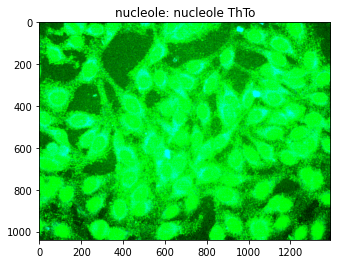

In [ ]:
for i in range(4):
    title = group_names[0]+ ': '+ all_class_names[0][2]
    plt.title(title)
    plt.imshow(all_cells[0][2][i])
    plt.show()

A function that applies a mask to its corresponding image

In [ ]:
def apply_mask (img, mask):
  cells = []
  for i in range(1, np.amax(mask)+1):
    x, y = np.where(mask==i)
    cells.append(img[np.amin(x):np.amax(x)+1, np.amin(y):np.amax(y)+1])
  return cells

# Useless still

In [ ]:
'''
# Shuffle data randomly
rand_idx = np.arange(2*num)
np.random.shuffle(rand_idx)

# Use as new variables
X_train=X_train[rand_idx]
Y_train=Y_train[rand_idx]
'''

'\n# Shuffle data randomly\nrand_idx = np.arange(2*num)\nnp.random.shuffle(rand_idx)\n\n# Use as new variables\nX_train=X_train[rand_idx]\nY_train=Y_train[rand_idx]\n'